In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
#import holidays
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
#holiday_list = holidays.India(years=2016)

In [2]:
train_data = pd.read_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/train.csv")
test_data = pd.read_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/test.csv")
columns=train_data.drop(['id_code', 'target'], axis=1).columns
tot_data = pd.concat([train_data[columns], test_data[columns]])

In [3]:
train_data['current_datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
train_data['datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
test_data['current_datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
test_data['datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
train_columns = train_data.columns

In [4]:
source_station = tot_data[['source_name', 'country_code_source', 'longitude_source', 'latitude_source', 'mean_halt_times_source']]
destination_station = tot_data[['destination_name', 'country_code_destination', 'longitude_destination', 'latitude_destination', 'mean_halt_times_destination']]
source_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']
destination_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']

In [5]:
station_detail = pd.concat([source_station, destination_station])
station_detail['id'] = station_detail['name'].apply(lambda x: int(x[8:]))
station_detail = station_detail.drop_duplicates()
station_detail.sort_values('id', inplace=True)
station_detail.reset_index(drop=True, inplace=True)
station_detail = station_detail.fillna(method = 'bfill')
station_detail

,name,country_code,latitude,longitude,mean_halt_times,id
0,station$0,logbp,-0.126061,51.531040,0.000000,0
1,station$1,logbp,-0.126061,51.531040,0.000000,1
2,station$2,logbp,-0.126061,51.531040,0.000000,2
3,station$3,logbp,0.321070,51.443040,0.000000,3
4,station$11,zxdec,6.958823,50.942721,12.540462,11
...,...,...,...,...,...,...
304,station$640,whber,2.999286,50.772072,22.445087,640
305,station$642,whber,2.736343,50.854449,22.445087,642
306,station$643,whber,3.130412,50.949025,35.274566,643
307,station$644,whber,3.212088,50.921149,35.274566,644


In [6]:
station_dict = {}
for x,y in zip(station_detail['name'], station_detail['id']):
    station_dict[x] = y

In [7]:
country_code = station_detail['country_code'].sort_values()
country_code = country_code.drop_duplicates()
country_code.reset_index(drop=True, inplace=True)
country_code = country_code.reset_index(drop=False)
country_code.columns=['id', 'code']
country_code

,id,code
0,0,aqfre
1,1,logbp
2,2,qwnll
3,3,whber
4,4,wsluu
5,5,zxdec


In [8]:
country_dict={}
for x,y in zip(country_code['code'], country_code['id']):
    country_dict[x]=y

In [9]:
train_detail = train_data.loc[:,['id_code', 'current_datetime', 'train_name', 'source_name', 'destination_name', 'target']]
train_detail = train_detail.drop_duplicates()
train_detail.sort_values('current_datetime', inplace=True)
train_detail.reset_index(drop=True, inplace=True)
train_detail.reset_index(inplace=True)
train_detail.rename(columns={'current_datetime':'datetime', 'index':'train_id', 'target':'passenger_demand', 
                             'source_name':'source', 'destination_name': 'destination'}, inplace=True)
train_detail

,train_id,id_code,datetime,train_name,source,destination,passenger_demand
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,station$147,station$1,high
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,station$147,station$1,high
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,station$147,station$1,high
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,station$147,station$1,high
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,station$147,station$1,high
...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,station$130,station$279,medium
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,station$544,station$266,medium
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,station$147,station$159,high
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,station$147,station$422,low


In [10]:
train_dict = {}
for x,y in zip(train_detail['train_name'], train_detail['train_id']):
    train_dict[x] = y

In [11]:
station_detail['country_code'] = station_detail['country_code'].apply(lambda x: country_dict[x])
train_detail['source'] = train_detail['source'].apply(lambda x: station_dict[x])
train_detail['destination'] = train_detail['destination'].apply(lambda x: station_dict[x])

In [12]:
def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
columns_with_nulls = train_data.columns[train_data.isna().sum()>0]
columns_with_nulls

Index(['country_code_source', 'longitude_source', 'latitude_source',
       'mean_halt_times_source', 'country_code_destination',
       'longitude_destination', 'latitude_destination',
       'mean_halt_times_destination'],
      dtype='object')

In [14]:
train_data = train_data.merge(station_detail, left_on='source_name', right_on='name', how='left')

In [15]:
train_data = train_data.merge(station_detail, left_on='destination_name', right_on='name', how='left', suffixes=('_source', '_destination'))

In [16]:
train_data = train_data.dropna(axis=1)[train_columns]
train_data.set_index('current_datetime', inplace=True)

In [17]:
train_data['distance_between_stations'] = get_distance(train_data['latitude_source'].values, train_data['longitude_source'].values, 
                                                       train_data['latitude_destination'].values, train_data['longitude_destination'].values)

In [18]:
datetime_detail = pd.DataFrame(pd.date_range('2016-06-01', '2016-11-30', freq='s'), columns=['datetime'])
datetime_detail['datetime'] = pd.to_datetime(datetime_detail['datetime'])

In [19]:
datetime_detail['day'] = datetime_detail['datetime'].dt.weekday.astype(int)
datetime_detail['is_weekend']=0
datetime_detail.loc[datetime_detail['day']>4, 'is_weekend']=1
datetime_detail['hours'] = datetime_detail['datetime'].dt.hour.astype(int)
datetime_detail['minutes'] = datetime_detail['datetime'].dt.minute.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour
test_data['minutes'] = test_data['datetime'].dt.month.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)

In [20]:
train_data

,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,...,country_code_destination,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,current_day,is_weekend,datetime,distance_between_stations
current_datetime,,,,,,,,,,,,,,,,,,,,,
2016-07-27 20:05:51,isfywypmkqqhyft,2016-07-27,08:05:51 PM,station$147,station$1,ICZVZS,high,3,50.845658,4.356801,...,1,51.531040,-0.126061,0.000000,2016,30,Wednesday,False,2016-07-27 20:05:51,504.411242
2016-07-27 20:06:11,mqsfxyvuqpbwomk,2016-07-27,08:06:11 PM,station$147,station$1,ICZVZS,high,3,50.845658,4.356801,...,1,51.531040,-0.126061,0.000000,2016,30,Wednesday,False,2016-07-27 20:06:11,504.411242
2016-07-27 20:08:57,alspwwtbdvqsgby,2016-07-27,08:08:57 PM,station$147,station$1,ICZVZS,high,3,50.845658,4.356801,...,1,51.531040,-0.126061,0.000000,2016,30,Wednesday,False,2016-07-27 20:08:57,504.411242
2016-07-27 20:09:08,szitxhhqduyrqpg,2016-07-27,08:09:08 PM,station$147,station$1,ICZVZS,high,3,50.845658,4.356801,...,1,51.531040,-0.126061,0.000000,2016,30,Wednesday,False,2016-07-27 20:09:08,504.411242
2016-07-27 20:11:01,krisdqzczivvwcp,2016-07-27,08:11:01 PM,station$147,station$1,ICZVZS,high,3,50.845658,4.356801,...,1,51.531040,-0.126061,0.000000,2016,30,Wednesday,False,2016-07-27 20:11:01,504.411242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-05 15:12:10,gfnxmbjcdyjdbeo,2016-10-05,03:12:10 PM,station$130,station$279,ICZVZY,medium,3,50.859663,4.360846,...,3,50.747927,5.079660,87.508671,2016,40,Wednesday,False,2016-10-05 15:12:10,80.907283
2016-10-05 18:14:27,mcfgyjeuatomuub,2016-10-05,06:14:27 PM,station$544,station$266,ICWZZV,medium,3,51.035896,3.710675,...,3,50.882280,4.715866,351.916185,2016,40,Wednesday,False,2016-10-05 18:14:27,113.098308
2016-10-05 18:23:44,rwhslfljqeapqhw,2016-10-05,06:23:44 PM,station$147,station$159,SZZTSS,high,3,50.845658,4.356801,...,3,50.645423,4.365368,48.872832,2016,40,Wednesday,False,2016-10-05 18:23:44,22.228054


In [21]:
train_data.isna().sum()

id_code                        0
current_date                   0
current_time                   0
source_name                    0
destination_name               0
train_name                     0
target                         0
country_code_source            0
longitude_source               0
latitude_source                0
mean_halt_times_source         0
country_code_destination       0
longitude_destination          0
latitude_destination           0
mean_halt_times_destination    0
current_year                   0
current_week                   0
current_day                    0
is_weekend                     0
datetime                       0
distance_between_stations      0
dtype: int64

In [22]:
train_data['passenger_demand_high'] = np.where(train_data['target']=='high', 1, 0)
train_data['passenger_demand_medium'] = np.where(train_data['target']=='medium', 1, 0)
train_data['passenger_demand_low'] = np.where(train_data['target']=='low', 1, 0)

D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


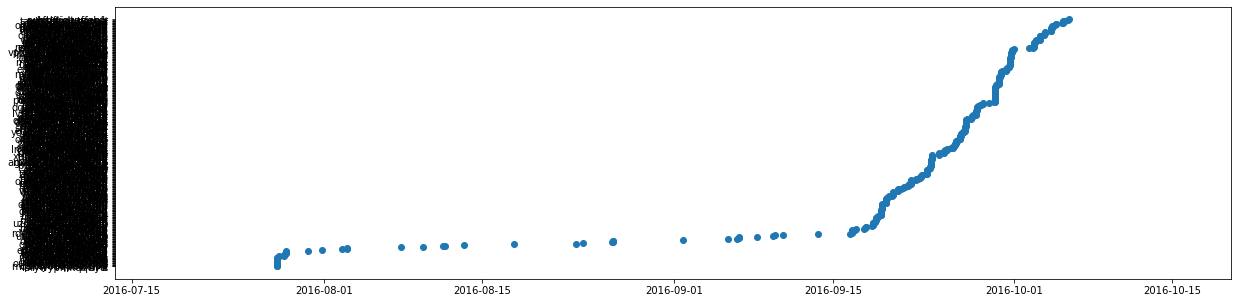

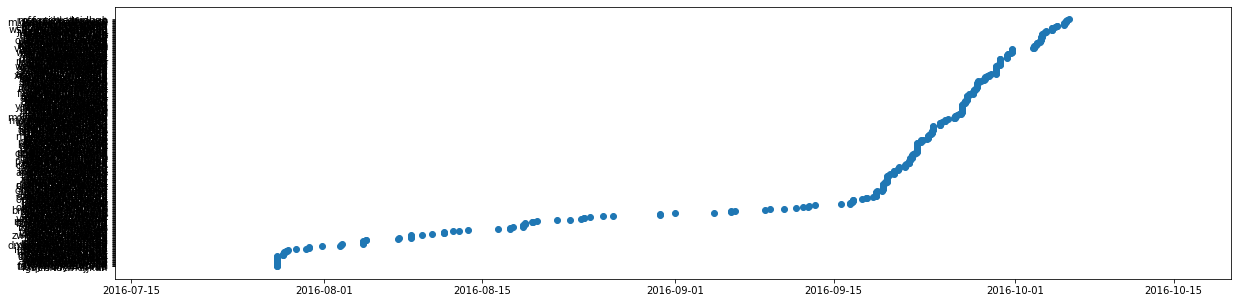

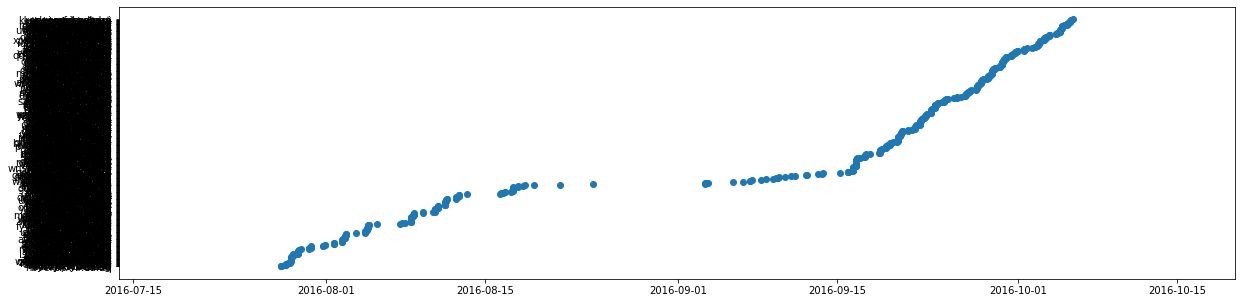

In [23]:
x_values = train_data.loc[train_data['target']=='high', 'datetime']
y_values = train_data.loc[train_data['target']=='high', 'id_code']
plt.figure(figsize=(20,5))
#plt.yticks(range(48,53))
#plt.xticks(range(-3,10))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['target']=='medium', 'datetime']
y_values = train_data.loc[train_data['target']=='medium', 'id_code']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['target']=='low', 'datetime']
y_values = train_data.loc[train_data['target']=='low', 'id_code']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)

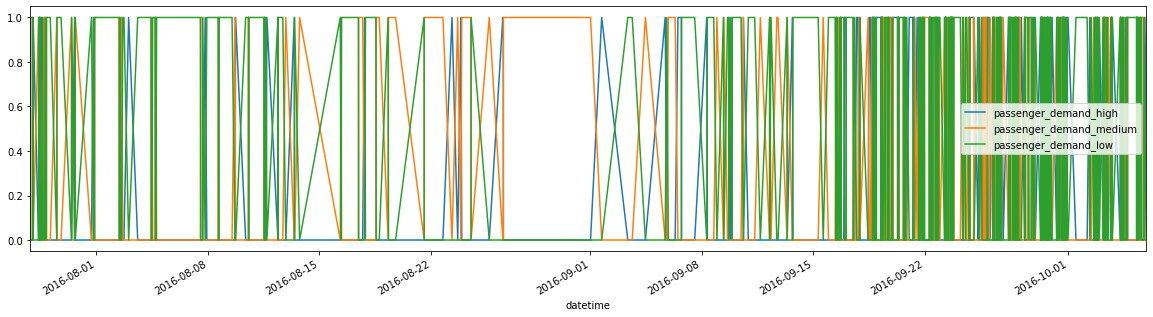

In [24]:
train_data.groupby('datetime')[['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low']].mean().plot(figsize=(20,5))

In [25]:
trains_df = train_data.groupby(['train_name'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
trains_df.columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob']
trains_df

,train_high_prob,train_low_prob,train_medium_prob
train_name,,,
EURRZAS,0.0,1.000000,0.000000
ICRYVY,0.0,1.000000,0.000000
ICRYVZ,0.0,1.000000,0.000000
ICRYWA,1.0,0.000000,0.000000
ICRYZV,1.0,0.000000,0.000000
...,...,...,...
XUWA,0.4,0.400000,0.200000
XWZV,0.5,0.375000,0.125000
XXZV,0.0,0.000000,1.000000


In [26]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
trains_low = trains_df[trains_df['train_low_prob']==1].index
trains_medium = trains_df[trains_df['train_medium_prob']==1].index
trains_high = trains_df[trains_df['train_high_prob']==1].index
print(len(trains_low), len(trains_medium), len(trains_high))
print(intersection(trains_low, trains_medium), intersection(trains_medium, trains_low))
print(intersection(trains_medium, trains_high), intersection(trains_high, trains_medium))
print(intersection(trains_high, trains_low), intersection(trains_low, trains_high))

99 194 116
[] []
[] []
[] []


In [27]:
trains_df.reset_index(inplace=True)
train_data = train_data.merge(trains_df, left_on='train_name', right_on = 'train_name', how='left')

In [28]:
train_data['target'] = np.where(train_data['target']=='low', 0, 
                                          np.where(train_data['target']=='medium', 1, 2))

In [29]:
stations_df = train_data.groupby(['source_name', 'destination_name'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
stations_df.columns = ['station_high_prob', 'station_low_prob', 'station_medium_prob']
stations_df

station_high_prob  station_low_prob  \
source_name destination_name                                        
station$0   station$643                     1.0               0.0   
station$100 station$130                     0.0               1.0   
station$106 station$108                     0.0               1.0   
            station$114                     1.0               0.0   
            station$117                     0.0               0.0   
...                                         ...               ...   
station$96  station$92                      0.0               1.0   
station$99  station$100                     0.0               1.0   
            station$106                     0.0               1.0   
            station$147                     0.0               0.0   
            station$91                      0.0               0.0   

                              station_medium_prob  
source_name destination_name                       
station$0   station$643                       0.0  
station$100 station$130                       0.0  
station$106 station$108                       0.0  
            station$114                       0.0  
            station$117                       1.0  
...                                           ...  
station$96  station$92                        0.0  
station$99  station$100                       0.0  
            station$106                       0.0  
            station$147                       1.0  
            station$91                        1.0  

[590 rows x 3 columns]

In [30]:
stations_low = stations_df[stations_df['station_low_prob']==1].index
stations_medium = stations_df[stations_df['station_medium_prob']==1].index
stations_high = stations_df[stations_df['station_high_prob']==1].index
print(len(stations_low), len(stations_medium), len(stations_high))
print(intersection(stations_low, stations_medium), intersection(stations_medium, stations_low))
print(intersection(stations_medium, stations_high), intersection(stations_high, stations_medium))
print(intersection(stations_high, stations_low), intersection(stations_low, stations_high))

126 196 119
[] []
[] []
[] []


In [31]:
#stations_df.reset_index(inplace=True)
train_data = train_data.merge(stations_df, left_on=['source_name', 'destination_name'], right_on = ['source_name', 'destination_name'], how='left')

In [32]:
test_data = test_data.merge(trains_df, left_on='train_name', right_on='train_name', how='left')

In [33]:
test_data = test_data.merge(stations_df, left_on=['source_name', 'destination_name'], right_on=['source_name', 'destination_name'], how='left')

In [34]:
test_data['source_name'] = test_data['source_name'].apply(lambda x: station_dict[x])
test_data['destination_name'] = test_data['destination_name'].apply(lambda x: station_dict[x])

In [35]:
test_data[['station_high_prob', 'station_low_prob', 'station_medium_prob', 'train_high_prob', 'train_low_prob', 'train_medium_prob']] = test_data[['station_high_prob', 'station_low_prob', 'station_medium_prob', 'train_high_prob', 'train_low_prob', 'train_medium_prob']].fillna(0)

In [36]:
test_data['current_day'] = test_data['datetime'].dt.weekday.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour.astype(int)
test_data['minutes'] = test_data['datetime'].dt.minute.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)
test_data['distance_between_stations'] = get_distance(test_data['latitude_source'].values, test_data['longitude_source'].values, 
                                                       test_data['latitude_destination'].values, test_data['longitude_destination'].values)

In [37]:
test_data['country_code_source'] = test_data['country_code_source'].apply(lambda x: country_dict[x])
test_data['country_code_destination'] = test_data['country_code_destination'].apply(lambda x: country_dict[x])

In [38]:
train_data['hours'] = train_data['datetime'].dt.hour.astype(int)
train_data['minutes'] = train_data['datetime'].dt.minute.astype(int)
train_data['is_weekend'] = (train_data['is_weekend']*1).astype(int)
train_data['current_day'] = train_data['datetime'].dt.weekday.astype(int)

In [39]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(train_data[['mean_halt_times_source', 'mean_halt_times_destination']])
train_data.loc[:,['mean_halt_times_source', 'mean_halt_times_destination']] = scale.transform(train_data[['mean_halt_times_source', 'mean_halt_times_destination']])
test_data.loc[:,['mean_halt_times_source', 'mean_halt_times_destination']] = scale.transform(test_data[['mean_halt_times_source', 'mean_halt_times_destination']])                             

In [40]:
def to_categ(data, ditinct_classes):
    new_data = []
    for i in range(len(ditinct_classes)):
        new_data.append(np.where(data==ditinct_classes[i],1,0))
    return np.array(new_data).T
for col in ['current_day', 'country_code_source', 'country_code_destination']:
    col_names = train_data[col].unique()
    col_names = [str(col+'_'+str(x)) for x in col_names]
    temp = pd.DataFrame(to_categ(train_data[col], col_names), columns = col_names)
    train_data[temp.columns] = temp
    temp = pd.DataFrame(to_categ(test_data[col], col_names), columns = col_names)
    test_data[temp.columns] = temp
#train_data.drop(['current_day', 'country_code_source', 'country_code_destination'], axis=1, inplace=True)
#test_data.drop(['current_day', 'country_code_source', 'country_code_destination'], axis=1, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [41]:
train_data.columns

Index(['id_code', 'current_date', 'current_time', 'source_name',
       'destination_name', 'train_name', 'target', 'country_code_source',
       'longitude_source', 'latitude_source', 'mean_halt_times_source',
       'country_code_destination', 'longitude_destination',
       'latitude_destination', 'mean_halt_times_destination', 'current_year',
       'current_week', 'current_day', 'is_weekend', 'datetime',
       'distance_between_stations', 'passenger_demand_high',
       'passenger_demand_medium', 'passenger_demand_low', 'train_high_prob',
       'train_low_prob', 'train_medium_prob', 'station_high_prob',
       'station_low_prob', 'station_medium_prob', 'hours', 'minutes',
       'current_day_2', 'current_day_3', 'current_day_4', 'current_day_5',
       'current_day_6', 'current_day_0', 'current_day_1',
       'country_code_source_3', 'country_code_source_4',
       'country_code_source_1', 'country_code_source_2',
       'country_code_destination_1', 'country_code_destination_3'

In [42]:
train_columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours', 'minutes', 'current_day_2', 
                 'current_day_3', 'current_day_4', 'current_day_5', 'current_day_6', 'current_day_0', 'current_day_1', 'country_code_source_3', 'country_code_source_4', 
                 'country_code_source_1', 'country_code_source_2', 'country_code_destination_1', 'country_code_destination_3', 'country_code_destination_0', 
                 'country_code_destination_2', 'country_code_destination_5', 'mean_halt_times_source', 'mean_halt_times_destination','hours','minutes', 
                 'is_weekend', 'distance_between_stations'] #'train_high_prob', 'train_low_prob', 'train_medium_prob', 
X = train_data[train_columns]
Y = train_data['target']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)

In [43]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=8, splitter='random')
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

In [44]:
dt_clf.fit(x_train, y_train)
print(dt_clf.score(x_train, y_train))
print(dt_clf.score(x_test, y_test))

0.8181818181818182
0.7859922178988327


In [45]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(dt_clf.predict(x_test), y_test))
print(f1_score(dt_clf.predict(x_test), y_test, average='macro'))

[[188  33   0]
 [  5  94  35]
 [ 20  17 122]]
0.7715901128481804


In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
print(rf_clf.score(x_train, y_train))
print(rf_clf.score(x_test, y_test))

0.987012987012987
0.857976653696498


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
print(confusion_matrix(rf_clf.predict(x_test), y_test))
print(f1_score(rf_clf.predict(x_test), y_test, average='macro'))

[[193  14   8]
 [ 12 116  17]
 [  8  14 132]]
0.8511706410130698


In [48]:
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier(criterion='entropy', n_estimators=30, bootstrap=True, max_features=None, max_depth=7, max_leaf_nodes=7)
et_clf

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                     max_depth=7, max_features=None, max_leaf_nodes=7,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [49]:
et_clf.fit(x_train, y_train)
print(et_clf.score(x_train, y_train))
print(et_clf.score(x_test, y_test))

0.887012987012987
0.8871595330739299


In [50]:
print(confusion_matrix(et_clf.predict(x_test), y_test))
print(f1_score(et_clf.predict(x_test), y_test, average='macro'))

[[195  13   1]
 [  8 119  14]
 [ 10  12 142]]
0.8813311793014006


In [51]:
test_pred = dt_clf.predict(x_test)
test_pred = np.vstack((test_pred, rf_clf.predict(x_test)))
test_pred = np.vstack((test_pred, et_clf.predict(x_test)))
test_pred = test_pred.T

In [52]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [53]:
print(f1_score(result, y_test, average='macro'))

0.7715901128481804


In [54]:
test_pred = dt_clf.predict(test_data[train_columns])
test_pred = np.vstack((test_pred, rf_clf.predict(test_data[train_columns])))
test_pred = np.vstack((test_pred, et_clf.predict(test_data[train_columns])))
test_pred = test_pred.T

In [55]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [56]:
result = np.array(result).astype(int)
print(np.unique(result, return_counts=True))

(array([0, 1, 2]), array([521, 204, 239], dtype=int64))


In [57]:
submission = {}
submission['id_code'] = test_data['id_code']
submission['target'] = np.where(result==0, 'low', np.where(result==1, 'medium', 'high'))
submission=pd.DataFrame(submission)
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission_v1.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([239, 521, 204], dtype=int64))


In [58]:
et_clf.feature_importances_

array([0.17280783, 0.07989717, 0.47541011, 0.10000755, 0.09540272,
       0.07647463, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [59]:
test_pred = et_clf.predict(test_data[train_columns])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission_v2.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([242, 180, 542], dtype=int64))


In [60]:
dt_clf.feature_importances_

array([0.11985743, 0.13433789, 0.46177656, 0.03726454, 0.19932805,
       0.04743553, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [61]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.01, multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
log_reg.fit(x_train, y_train)
print(log_reg.score(x_train, y_train))
print(log_reg.score(x_test, y_test))

0.8662337662337662
0.8560311284046692


In [63]:
print(confusion_matrix(log_reg.predict(x_test), y_test))
print(f1_score(log_reg.predict(x_test), y_test, average='macro'))

[[206  29  13]
 [  4 100  10]
 [  3  15 134]]
0.8454056806186748


In [64]:
#Only Logistic Regression
test_pred = log_reg.predict(test_data[train_columns])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission_v3.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([263, 507, 194], dtype=int64))


In [65]:
train_columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob',  'mean_halt_times_source', 'mean_halt_times_destination','hours','minutes', 
                 'is_weekend', 'distance_between_stations', 'country_code_source', 'country_code_destination', 'current_day', 'hours', 'minutes'] 
X = train_data[train_columns]
Y = train_data['target']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)
categoricals = ['country_code_source', 'country_code_destination', 'current_day', 'hours', 'minutes']

In [66]:
import lightgbm as lgb
params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class':3,
            'metric': {'multi_logloss'},
            'subsample': 0.5,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'pos_bagging_fraction':0.7,
            'neg_bagging_fraction':0.2,
            'bagging_freq':2,
            'is_unbalance':True,
            'num_leaves': 2,
            'max_depth': 2,
            }

lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
lgb_eval = lgb.Dataset(x_test, y_test, categorical_feature=categoricals)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=10,
               verbose_eval = 10)

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.659315	valid_1's multi_logloss: 0.661084
[20]	training's multi_logloss: 0.481035	valid_1's multi_logloss: 0.484488
[30]	training's multi_logloss: 0.385953	valid_1's multi_logloss: 0.388963
[40]	training's multi_logloss: 0.32991	valid_1's multi_logloss: 0.335309
[50]	training's multi_logloss: 0.294165	valid_1's multi_logloss: 0.302034
[60]	training's multi_logloss: 0.270122	valid_1's multi_logloss: 0.283692
[70]	training's multi_logloss: 0.251431	valid_1's multi_logloss: 0.270263
[80]	training's multi_logloss: 0.236487	valid_1's multi_logloss: 0.262852
[90]	training's multi_logloss: 0.225212	valid_1's multi_logloss: 0.256052
[100]	training's multi_logloss: 0.216414	valid_1's multi_logloss: 0.253795
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.219811	valid_1's multi_logloss: 0.25341


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [67]:
from sklearn.metrics import accuracy_score
print(confusion_matrix(np.argmax(gbm.predict(x_test), axis=1), y_test))
print("F1 Score : ",f1_score(np.argmax(gbm.predict(x_test), axis=1), y_test, average='macro'))
print("Accuracy Score : ", accuracy_score(np.argmax(gbm.predict(x_test), axis=1), y_test))

[[194   8   5]
 [ 10 122   5]
 [  9  14 147]]
F1 Score :  0.8970731649173649
Accuracy Score :  0.9007782101167315


In [68]:
test_pred = np.argmax(gbm.predict(test_data[train_columns]), axis=1)
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission_v4.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([228, 404, 332], dtype=int64))
